# covid-timex.it: A Website for Covid-19 Monitoring-as-a-service
The goal of this Jupyter notebook is to explain the code and architecture of the [covid-timex.it](covid-timex.it) website.

This website, online from November 2020, uses TIMEX in order to daily ingest the time-series related to the Covid-19 pandemic in Italy, made available by the italian _Protezione Civile_ at this GitHub repository: https://github.com/pcm-dpc/COVID-19

The more recent available forecasts are made available in the form of plots, built using the [Dash](https://dash.plotly.com/) Python library.

## Architecture
The general architecture of the website is shown in the figure:

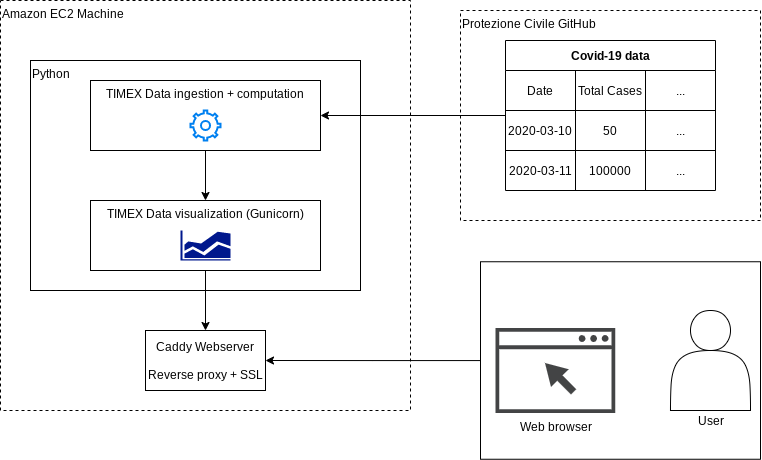

The site is hosted on an Amazon EC2 machine. 
Daily, the data ingestion and data computation part of TIMEX ingests the time-series available on the Protezione Civile GitHub repository.
The data visualization part, which provide a webpage built with Dash, is made available using the [Gunicorn](https://gunicorn.org/) webserver.

Lastly, the webpage is hosted for the public using the webserver [Caddy](https://caddyserver.com/) as reverse-proxy, in order to provide SSL.

Details on all the parts follow.

### Data ingestion and data computation
This parts ingests the time-series provided by the Protezione Civile, builds the predictions using the Facebook Prophet model (the LSTM works, but it is too heavy for the poor and little Amazon EC2 machine!) and dumps the obtained [TimeSeriesContainer](https://alexmv12.github.io/TIMEX/timex/timeseries_container.html#timex.timeseries_container.TimeSeriesContainer)s that will be used by the Data visualization part.

The reason for decoupling the data ingestion/computation and the data visualization part is that the first may require ~1 hour to compute, everyday: this way, the website is virtually never offline because, when the heavy computation are finished, the only thing to do is restart the data visualization part with the new, fresh, ready-to-use TimeSeriesContainers.

The code of `app.py` is:

In [ ]:
import json
import logging
import os
import pickle
import sys
import webbrowser
import dateparser
import numpy

from pandas import read_csv, DataFrame

import timex.data_ingestion
from timex.data_prediction.xcorr import calc_xcorr

from timex.data_ingestion import add_freq, select_timeseries_portion, add_diff_columns
from timex.data_prediction.models.prophet_predictor import FBProphetModel
from timex.data_prediction import create_timeseries_containers
from timex.timeseries_container import TimeSeriesContainer

log = logging.getLogger(__name__)


def compute():

    param_file_nameJSON = 'configurations/configuration_test_covid19italy.json'

    # Load parameters from config file.
    with open(param_file_nameJSON) as json_file:  # opening the config_file_name
        param_config = json.load(json_file)  # loading the json

    # Logging
    log_level = getattr(logging, param_config["verbose"], None)
    if not isinstance(log_level, int):
        log_level = 0
    # %(name)s for module name
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=log_level, stream=sys.stdout)

    # data ingestion
    log.info(f"Started data ingestion.")
    ingested_data = timex.data_ingestion.ingest_timeseries(param_config)  # ingestion of data

    # data selection
    log.info(f"Started data selection.")
    ingested_data = select_timeseries_portion(ingested_data, param_config)

    # Custom columns
    log.info(f"Adding custom columns.")
    ingested_data["New cases/tests ratio"] = [100 * (np / tamp) for np, tamp in
                                              zip(ingested_data['Daily cases'], ingested_data['Daily tests'])]

    # data prediction
    containers = create_timeseries_containers(ingested_data=ingested_data, param_config=param_config)


One of the key characteristics of TIMEX is the possibility to virtually configure each aspect of the ingestion-prediction-visualization pipeline with a simple, JSON, configuration file (in the code, it is loaded in the Python dictionary `param_config`). 
The content of the dict is (note that comments are not be present in the JSON):

```
{
  "activity_title": "Covid-19 Italy Analysis",
  "verbose": "INFO",  # Verbosity level
    
  # input parameters contains the parameters needed to retrieve and ingest the time-series data.
  "input_parameters": {
    "source_data_url": "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
    "columns_to_load_from_url": "data,nuovi_positivi,totale_positivi,variazione_totale_positivi,terapia_intensiva,totale_ospedalizzati,deceduti,tamponi",
    "datetime_column_name": "data",  # Parse the content of this column as datetime objects
    "index_column_name": "data",  # Use this column as index for all the time-series (the other columns)
    "add_diff_column": "terapia_intensiva,totale_ospedalizzati,deceduti,tamponi",  # Add the daily difference of this columns as new columns 
    "timeseries_names":  # Simple way to rename columns'names, if you don't like them.
    {
      "data": "Date",
      "nuovi_positivi": "Daily cases",
      "totale_positivi": "Total positives",
      "variazione_totale_positivi": "Total positives variation",
      "terapia_intensiva": "Total intensive care",
      "totale_ospedalizzati": "Total hospitalized",
      "deceduti": "Total deaths",
      "tamponi": "Tests",
      "terapia_intensiva_diff": "Daily intensive care",
      "totale_ospedalizzati_diff": "Daily hospitalized",
      "deceduti_diff": "Daily deaths",
      "tamponi_diff": "Daily tests"
    }
  },
    
  # selection_parameters contains the parameters needed to filter some rows in the dataset; we could omit this in this case.
  "selection_parameters": {
    "init_datetime": "2020-01-01T17:00:00",
    "end_datetime": "2023-01-22T17:00:00"
  },
    
  # model_parameters controls the forecast part. 
  "model_parameters": {
    "test_values": 5,  # use the last 5 values of the time-series as validation set.
    "delta_training_percentage": 10,  # the training windows are composed of the 10% of the time-series lengths; refer to 
                                      # documentation for more information on this.
    "prediction_lags": 10,  # predict the next 10 days
    "possible_transformations" : "none,log_modified",  # test which feature transformation between these 
                                                       # (no transformation and modified log) works better
    "models": "fbprophet",  # use the Facebook Prophet model
    "main_accuracy_estimator": "mae"  # try to minimize the Mean Absolute Error, in general
  },
    
  # xcorr_parameters is used for the multivariate prediction part
  "xcorr_parameters": {
    "xcorr_max_lags": 120,  # check the cross-correlation from -120 to +120 lags
    "xcorr_extra_regressor_threshold": 0.8,  # if you find that time-series b is cross-correlated with time-series
                                             # a with a cross-correlation > 0.8, use b to better predict a
    "xcorr_mode": "pearson",  # compute only the pearson coefficient
    "xcorr_mode_target": "pearson"  # use the pearson coefficient to select extra-regressors
  },
    
  # these parameters are needed for the historical prediction part: these are the predictions made
  # day-by-day on the past data, to check the performances on the past.
  "historical_prediction_parameters": {
    "initial_index": "2020-08-18",  # start from this index
    "save_path": "historical_predictions_italy_covid_fbprophet.pkl"  # save the historical predictions here
  },
    
  # visualization_parameters control the data visualization part, to customize the graphs.
  "visualization_parameters": {
    "xcorr_graph_threshold": 0.8,
    "box_plot_frequency": "1W",
  }
}
```

Once `containers` is created, it is saved in a file using the standard pickle module:

In [ ]:
with open(f"containers.pkl", 'wb') as input_file:
    pickle.dump(containers, input_file)

### Data visualization
The data visualiztion part is made with Gunicorn.
It is sufficient to load the computed TimeSeriesContainers, create the Dash children using TIMEX data visualization functions and launch the application with Gunicorn. The code of `app_load_from_dump.py` is:

In [ ]:
import json
import logging
import pickle

import dash
import dash_html_components as html
from datetime import datetime, timezone
import dash_core_components as dcc
import dateparser
from dash.dependencies import Input, Output
from pandas import read_csv

from timex.data_ingestion import add_diff_columns
from timex.data_visualization.functions import create_timeseries_dash_children, line_plot_multiIndex

log = logging.getLogger(__name__)


param_file_nameJSON = 'configurations/configuration_test_covid19italy.json'

# Load parameters from config file.
with open(param_file_nameJSON) as json_file:  # opening the config_file_name
    param_config = json.load(json_file)  # loading the json

# Load containers dump.
with open(f"containers.pkl", 'rb') as input_file:
    timeseries_containers = pickle.load(input_file)

# Data visualization
children_for_each_timeseries = [{
    'name': s.timeseries_data.columns[0],
    'children': create_timeseries_dash_children(s, param_config)
} for s in timeseries_containers]


# Initialize Dash app.
app = dash.Dash(__name__)
server = app.server

now = datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

disclaimer = [html.Div([
    html.H1("COVID-19 pandemic in Italy: monitoring and forecasting", style={'text-align': 'center'}),
    html.Hr(),
    html.Div(html.Img(src=app.get_asset_url('poli.png'), style={'width': 256}), style={'text-align': 'center'}),
    html.H4(
        "Dashboard by the Intelligent Embedded Systems (IES) research group of the Politecnico di Milano, Italy",
        style={'text-align': 'center', 'top-margin': '25px'}),
    html.Hr(),
    dcc.Markdown('''
        *Welcome to the monitoring and forecasting dashboard of the Coronavirus (COVID-19) pandemic in Italy provided by the Intelligent Embedded Systems (IES) research group of Politecnico di Milano, Italy.*

        The dashboard relies on *TIMEX*, a Python-based framework for automatic time series analysis developed by the IES research group.

        The dashboard is fed with the [data](https://github.com/pcm-dpc/COVID-19) provided by Italian Civil Protection from Feb. 21 2020. 
        In particular, the following COVID-19 data are considered:
        - **Daily cases**: New positive cases. This is the typical number reported by media.
        - **Total positives**: The total number of persons positive to Covid, in that time instant.
        - **Total positives variation**: Daily variation of the number of persons positive to Covid.
        - **Total intensive care**: Total number of patients in intensive care.
        - **Total hospitalized**: Total number of patients in hospitals.
        - **Total deaths**: Total number of deaths due to Covid-19.
        - **Daily intensive care**: New intensive care patients.
        - **Daily hospitalized**: New patients in hospital.
        - **Daily deaths**: Daily deaths.
        - **Daily tests**: Daily tests.
        - **Positive cases/test ratio**: Daily ratio of positive tests.
        - **Regions**: Mixed information about single regions.

        You can select the data to be visualized from the selector at the bottom of the page.

        For suggestions and questions contact:
        - Prof. Manuel Roveri - manuel.roveri (at) polimi.it
        - Ing. Alessandro Falcetta - alessandro.falcetta (at) mail.polimi.it

        *DISCLAIMER: The information on this site is not intended or implied to be a substitute for professional medical advice, diagnosis or treatment. Contents, including text, graphics, images and information, presented in or available on this web site are meant to help in advancing the understanding of the virus and informing the public.
         Information is subject to change without notice. You are encouraged to confirm any information obtained from or through this web site with other sources.*
        '''),
    html.Div("Last updated at (yyyy-mm-dd, UTC time): " + str(now)),
    html.Br(),
    html.H2("Please select the data of interest:")
], style={'width': '80%', 'margin': 'auto'}
), dcc.Dropdown(
    id='timeseries_selector',
    options=[{'label': i['name'], 'value': i['name']} for i in children_for_each_timeseries],
    value='Time-series'
), html.Div(id="timeseries_wrapper"), html.Div(dcc.Graph(), style={'display': 'none'})]
tree = html.Div(children=disclaimer, style={'width': '80%', 'margin': 'auto'})

app.layout = tree


@app.callback(
    Output(component_id='timeseries_wrapper', component_property='children'),
    [Input(component_id='timeseries_selector', component_property='value')]
)
def update_timeseries_wrapper(input_value):
    try:
        children = next(x['children'] for x in children_for_each_timeseries if x['name'] == input_value)
    except StopIteration:
        return html.Div(style={'padding': 200})

    return children

The app is launched with:

`gunicorn -b 0.0.0.0:8016 app_data_visualization:server`

Now the webpage is available at `http://0.0.0.0:8016`. We need to make it available to the public.

### Caddy webserver
Caddy is a simple webserver with automatic HTTPS. We use this to provide the website to the public, acting as a reverse-proxy.
Caddy is configured with a simple Caddyfile:

```
www.covid-timex.it {
    redir https://covid-timex.it{uri}
}

covid-timex.it {
    log {
        output file /var/log/caddy/timex_web.log
        format json
    }

    reverse_proxy localhost:8016
}
```